<a href="https://colab.research.google.com/github/imiled/DL_Tools_For_Finance/blob/master/cnn_captcha__teacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google's Colab specific magic to avoid warnings and incompatibility issues (more info here https://colab.research.google.com/notebooks/tensorflow_version.ipynb)
%tensorflow_version 1.x

# Disable extremely annoying and boring warnings about tensorflow deprecation
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Breaking a CAPTCHA system with the help of CNN

A CAPTCHA --*Completely Automated Public Turing test to tell Computers and Humans Apart* -- is a type of challenge-response test used in computing to determine whether or not the user is human. For instance, CAPTCHAs are one of the most utilized solutions for preventing bots from automatically filling out forms to access websites.

In this notebook we will teach you how to defeat a captcha system using CNN.

## Dataset


The dataset we will work with was generated with the [Really Simple CAPTCHA’ plugin](https://wordpress.org/plugins/really-simple-captcha/) and consist of 10k synthetic four letter  CAPTCHA images -- “O” or “I” are avoided in the codes -- drawn from four different fonts.
 
The goal is to recognize among 32 possible letters wich ones conform the captcha image.

In [ ]:
import pylab as plt
import matplotlib.image as im
import numpy as np
import glob
import os, os.path
import cv2
import imutils # From Adrian Rosebrock http://www.pyimagesearch.com/
import keras
import pickle

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.utils import plot_model
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


%matplotlib inline

Using TensorFlow backend.


In [ ]:
# Some initalizations for reproducibility

np.random.seed(42)
tf.set_random_seed(42)

In [ ]:
%%shell

wget https://s3-us-west-2.amazonaws.com/mlif-example-code/solving_captchas_code_examples.zip
unzip solving_captchas_code_examples.zip

--2019-12-22 18:16:23--  https://s3-us-west-2.amazonaws.com/mlif-example-code/solving_captchas_code_examples.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.220.104
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.220.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13863487 (13M) [application/zip]
Saving to: ‘solving_captchas_code_examples.zip’

solving_captchas_co 100%[===================>]  13.22M  7.56MB/s    in 1.7s    

2019-12-22 18:16:25 (7.56 MB/s) - ‘solving_captchas_code_examples.zip’ saved [13863487/13863487]

Archive:  solving_captchas_code_examples.zip
   creating: solving_captchas_code_examples/
  inflating: solving_captchas_code_examples/extract_single_letters_from_captchas.py  
   creating: solving_captchas_code_examples/extracted_letter_images/
   creating: solving_captchas_code_examples/generated_captcha_images/
  inflating: solving_captchas_code_examples/generated_captcha_images

In [ ]:
path2images = "./solving_captchas_code_examples/generated_captcha_images/"

In [ ]:
captcha_image_files = glob.glob(path2images + "*")
print("\n".join(captcha_image_files[:10]))
print("\nNumber of captchas: %d" %len(captcha_image_files))

./solving_captchas_code_examples/generated_captcha_images/3B7F.png
./solving_captchas_code_examples/generated_captcha_images/E9EZ.png
./solving_captchas_code_examples/generated_captcha_images/AKY7.png
./solving_captchas_code_examples/generated_captcha_images/9TDJ.png
./solving_captchas_code_examples/generated_captcha_images/Y9MX.png
./solving_captchas_code_examples/generated_captcha_images/HUTQ.png
./solving_captchas_code_examples/generated_captcha_images/D755.png
./solving_captchas_code_examples/generated_captcha_images/4QG9.png
./solving_captchas_code_examples/generated_captcha_images/RK9K.png
./solving_captchas_code_examples/generated_captcha_images/K9R8.png

Number of captchas: 9955


In [ ]:
# Let's shuffle the images and split them intro train and test

np.random.shuffle(captcha_image_files)
train = captcha_image_files[:int(len(captcha_image_files) * 0.8)]
test = captcha_image_files[int(len(captcha_image_files) * 0.8):]

print("Training set length: %d" % len(train))
print("Test set length: %d" % len(test))

Training set length: 7964
Test set length: 1991


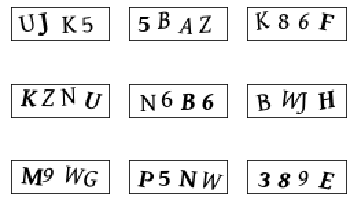

In [ ]:
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    image = im.imread(captcha_image_files[i])
    plot = plt.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Preprocessing

In order to solve the CAPTCHA challenge we propose the following procedure:

1.   Split the image in four separate 'subimages' in a way that each one contains just a single letter

2.   Apply and train a CNN to categorize each individual letter.

#### Step 1: Extract single letters from CAPTCHA images

Concerning the first point, note that we can’t just split the images into four equal-size chunks because the CAPTCHA randomly places the letters in different horizontal locations. 

So we should delimite the boundaries or contours of the letters to separate them correctly. findContours() function of OpenCV can help us to implement a solution to this particular problem.

In [ ]:
def get_boundary(captcha_image_file):

    # Since the filename contains the captcha text (i.e. "2A2X.png" has the text "2A2X"),
    # grab the base filename as the text
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]

    # Load the image and convert it to grayscale
    image = cv2.imread(captcha_image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # Threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1] #  Automatic image thresholding
    # https://en.wikipedia.org/wiki/Otsu%27s_method

    # Find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    contours = contours[0] if imutils.is_cv2() else contours[1]
    return captcha_correct_text, gray, contours

Ex: Plot the contours of a captcha image using the above function

error: ignored

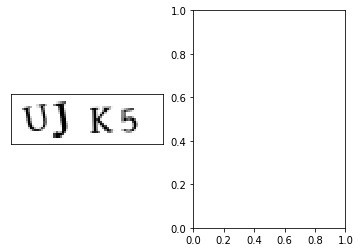

In [ ]:
image_file = captcha_image_files[0]
captcha_correct_text, gray, contours = get_boundary(image_file)

ax = plt.subplot(1,2,1)
image = im.imread(image_file)
plot = plt.imshow(image)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,2,2)
cv2.drawContours(image, contours, -1, (0,255,0))
plot = plt.imshow(image.astype(np.uint8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

As sometimes the CAPTCHAs have overlapping letters, we need to ensure that the extracted regions don't mash together two letters.

A simple hack here is to say that if a single contour area is a lot wider than it is tall, that means we probably have two letters squished together. In that case, we can just split the conjoined letter in half down the middle and treat it as two separate letters:

In [ ]:
def split_overlapping_letters(contour):

    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)

    # Compare the width and height of the contour to detect letters that
    # are conjoined into one chunk

    letter_image_regions = []

    if w / h > 1.25:
        # This contour is too wide to be a single letter!
        # Split it in half into two letter regions!
        half_width = int(w / 2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))

    else:
        # This is a normal letter by itself
        letter_image_regions.append((x, y, w, h))
        
    return letter_image_regions

Ex: Plot the bounding rectangles of a captcha image' letters using the above function

In [ ]:
image_file = captcha_image_files[0]
captcha_correct_text, gray, contours = get_boundary(image_file)

letter_image_regions = []

for contour in contours:
    letter_image_regions += split_overlapping_letters(contour)

ax = plt.subplot(1,2,1)
image = im.imread(image_file)
plot = plt.imshow(image)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,2,2)
image = im.imread(image_file)
cv2.drawContours(image, contours, -1, (0,255,0))

for i in range(len(letter_image_regions)):
    cv2.rectangle(image,(letter_image_regions[i][0],letter_image_regions[i][1]),
              (letter_image_regions[i][0]+letter_image_regions[i][2],
               letter_image_regions[i][1]+letter_image_regions[i][3]),(255,0,255),2)
    
plot = plt.imshow(image.astype(np.uint8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Ex.- Put all together and loop over the image path to get the single letters' corpus:

In [ ]:
letter_images_folder = "extracted_letter_images"

In [ ]:
counts = {}

# loop over the image paths
for (i, captcha_image_file) in enumerate(captcha_image_files):

    if ( (i+1)%100 == 0 and i>0):
      print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))

    captcha_correct_text, gray, contours = get_boundary(captcha_image_file)
    
    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    letter_image_regions = []

    for contour in contours:
        letter_image_regions += split_overlapping_letters(contour)

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Save out each letter as a single image
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_correct_text):

        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        # Get the folder to save the image in
        save_path = os.path.join(letter_images_folder, letter_text)

        # if the output directory does not exist, create it
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)

        # increment the count for the current key
        counts[letter_text] = count + 1

print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))

#### Step 2: Train the neural network to recognize single letters

We’ll use a simple convolutional neural network architecture with two convolutional layers and two fully-connected layers:

![CNN architecture](https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/13_CNN_Network_Model.png?raw=true)

Ex: Implement the above architecture using keras:

In [ ]:
def create_cnn():

    # Build the neural network!
    model = Sequential()

    # First convolutional layer with max pooling
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Second convolutional layer with max pooling
    model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Hidden layer with 500 nodes
    model.add(Flatten())
    model.add(Dense(500, activation="relu"))

    # Output layer with 32 nodes (one for each possible letter/number we predict)
    model.add(Dense(32, activation="softmax"))
    return model

Ex: visualize the architecture using Keras visualization tools to check it's similar to the above picture.

In [ ]:
model = create_cnn()

In [ ]:
plot_model(model, to_file='model.png')

Train the network using 10 epochs and save the model.
Use the next auxiliar function to resize an image to a given size:

In [ ]:
def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    :param image: image to resize
    :param width: desired width in pixels
    :param height: desired height in pixels
    :return: the resized image
    """

    # grab the dimensions of the image, then initialize
    # the padding values
    (h, w) = image.shape[:2]

    # if the width is greater than the height then resize along
    # the width
    if w > h:
        image = imutils.resize(image, width=width)

    # otherwise, the height is greater than the width so resize
    # along the height
    else:
        image = imutils.resize(image, height=height)

    # determine the padding values for the width and height to
    # obtain the target dimensions
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)

    # pad the image then apply one more resizing to handle any
    # rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

    # return the pre-processed image
    return image

Train the model:

In [ ]:
path2model_dir = "models"
path2model = os.path.join(path2model_dir + "captcha_model.hdf5")
path2labels = os.path.join(path2model_dir + "model_labels.dat") 

if not os.path.exists(path2model_dir):
    os.makedirs(path2model_dir)

In [ ]:
batch_size = 32
epochs = 10
verbose = 1

In [ ]:
# initialize the data and labels
data = []
labels = []

# Loop over the input images
for image_file in paths.list_images(letter_images_folder):

    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


# Scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(path2labels, "wb") as fout:
    pickle.dump(lb, fout)

## Build the neural network!
# If the model is not already created, uncomment the following line
# model = create_cnn()

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the neural network
model.fit(X_train, Y_train, \
          validation_data=(X_test, Y_test), \
          batch_size=batch_size, epochs=epochs, verbose=verbose)

# Save the trained model to disk
model.save(path2model)

## Solve CAPTCHAs

Finally, we use our trained model to solve CAPTCHAs. The steps to make the predictions are similar to the ones describe above:

- Break up the CAPTCHA image into four separate letter images (use the same approach we used to create the training dataset)

- Ask our neural network to make a separate prediction for each letter image.

- Use the four predicted letters as the answer to the CAPTCHA.

And that's all! Let's codify the predictions and have a look at the decoding CAPTCHAs:

In [ ]:
# Load up the model labels (so we can translate model predictions to actual letters)
with open(path2labels, "rb") as fin:
    lb = pickle.load(fin)

# Load the trained neural network
model = load_model(path2model)

figure = plt.figure(figsize=(20, 8))

# loop over the image paths
for i, image_file in enumerate(test[:9]):

    # Load the image and convert it to grayscale
    captcha_correct_text, gray, contours = get_boundary(image_file)
    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        letter_image_regions += split_overlapping_letters(contour)

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Create an output image and a list to hold our predicted letters
    output = cv2.merge([image] * 3)
    predictions = []

    # loop over the letters
    for letter_bounding_box in letter_image_regions:
      
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = resize_to_fit(letter_image, 20, 20)

        # Turn the single image into a 4d list of images to make Keras happy
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        # Ask the neural network to make a prediction
        prediction = model.predict(letter_image)

        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

    # Print the captcha's text
    label = image_file.split('.')[2].split('/')[-1]
    captcha_text = "".join(predictions)
    
    # Plot captcha, their predicted labels and ground truth
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(im.imread(image_file))
    # Set the title for each image
    ax.set_title("{}".format(captcha_text), color=("green" if captcha_text == label else "red"))


## References

https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710